In this notebook, we'll attempt to predict the UCI electricity demand dataset (see [here][0]).

[0]:https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014

# Load Data

We'll start by loading the model data:

In [1]:
from zero_ts_demo.imports import *
from zero_ts_demo import helpers as hp
from zero_ts_demo.load_data import load_model_data

In [2]:
MODEL_DATA = load_model_data()
df = MODEL_DATA.copy()
df.head()

,mt_004,mt_005,mt_006,mt_007,mt_009,mt_010,mt_011,mt_013,mt_014,mt_015,...,mt_360,mt_361,mt_362,mt_363,mt_364,mt_365,mt_366,mt_367,mt_368,mt_370
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Detrend Data

Now, we want to walk through one basic preparation step for time series forecasting: detrending. 

The trend of a time series is a direction that the data tends to over the long run. For example, a time series of the stock market over the past 100 years would have an upward trend. 

We want to try to separate out this trend component for at least two reasons. First, the trend is something of a known quantity and when predicting we want to focus on predicting the part of the data that is more variable. Second, many mathematical time series models make the assumption that the data are *stationary*, i.e. that the average of the data is zero. 

There exist different ways of separating the trend component from a time series; and one method is a simple moving average. In this project, we'll calculate a moving average, predict the difference between the moving average of kW and the value of kW, then when making a final prediction we'll add the moving average value back into the data. 

Let's demonstrate with a plot:

In [3]:
from zero_ts_demo import models as mod
# select one of the time series in the data, mt_005
df = MODEL_DATA.copy()
col = 'mt_005'
sl, _ = mod.train_test(df, col, rolling=3)

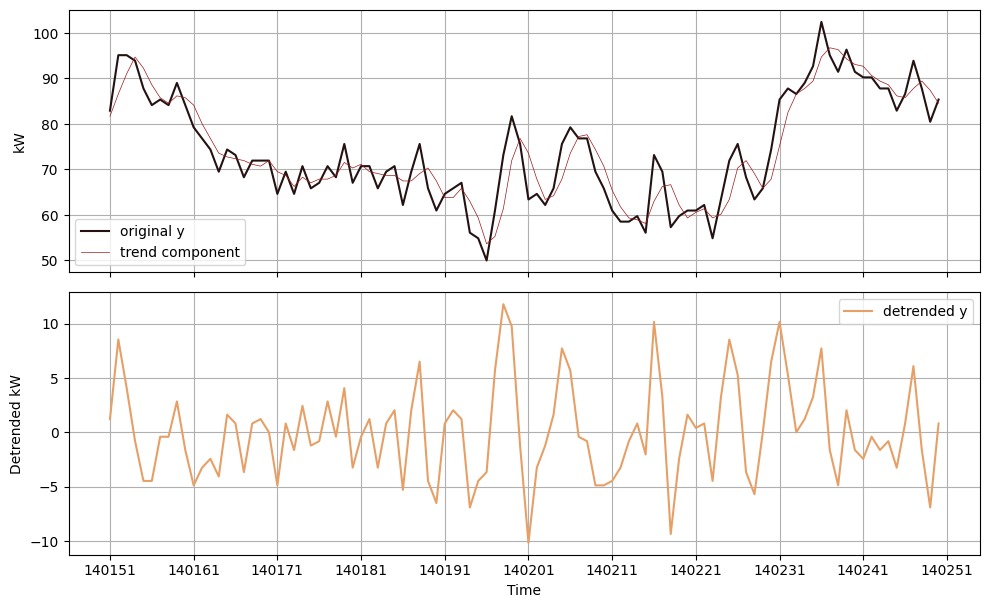

In [4]:
from matplotlib import pyplot as plt

d = sl.tail(100).copy()

w = 10
tick_width = 10
fig, (axu, axl) = plt.subplots(2, 1, figsize=(w, w/1.618), sharex=True)

axu.plot(d.index, d['y_original'], color='#241212', label='original y')
axu.plot(d.index, d['y_trend'], color='#9E1818', label='trend component', linewidth=0.5)
axu.set_xticks(range(d.index.min(), d.index.max()+tick_width, tick_width))
axu.grid(True)
axu.set_ylabel('kW')
axu.legend()
axl.plot(d.index, d['y_detrended'], color='#E6A067', label='detrended y')
axl.grid(True)
axl.legend()
axl.set_xlabel('Time')
axl.set_ylabel('Detrended kW')

plt.tight_layout()

On the top graph, we've plotted the raw data along with a moving average of the data. On the bottom graph, we've plotted the kW value minus the moving average of the kW value; and labeled this as "detrended y". 

Now, since our data is stationary, we can proceed to attemp to predict the values.

# Autoregression

In a nutshell, autoregression is using a simple OLS regression model to predict future values of the time series using past values. 

Put mathematically, an autoregressive model:

$$
Z_t = \phi_1 Z_{t-1} +\phi_2 Z_{t-2} + \dots + \phi_p Z_{t-p} + \alpha_t
$$

...where $Z_n$ is the $n$th value of the time series at hand, values of $\phi_x$ are regression coefficients (to be found in the process of fitting the model) and $\alpha_n$ is the value of a random, zero-centered white noise process [1]. 

The *order* of an autoregressive model is the value of $p$ in the above formulation. For example, an autoregressive model of order $3$ is:

$$
Z_t = \phi_1 Z_{t-1} +\phi_2 Z_{t-2} +\phi_3 Z_{t-3} + \alpha_t
$$

[1]: Wei, William W.S. Time Series Analysis: Univariate and Multivariate Methods. 2nd ed. Boston: Pearson/Addison Wesley, 2006.

The Python library `statsmodels` provides many time-series related features, including a convenient implementation of autoregression (AR) models, as well as a method of automatically determining the best order of the model (i.e. different model orders are automatically tried and the most effective order is chosen).

Included in this project is a class that has methods for fitting and inspecting an AR model:

In [5]:
from zero_ts_demo.helpers import display_source
display_source(mod.StatsmodelsARModel)

```python
class StatsmodelsARModel:
    """A prediction model using Statsmodels Autoregression (AR) model.

    This class encapsulates the process of fitting a Statsmodels AR
    model on the provided training data and making predictions on the
    test data.  The AR model automatically selects the autoregressive
    order based on the specified maximum lag.

    Attributes
    ----------
    sl_train : pandas.DataFrame
        The training data containing the time series to fit the model.
        Expected columns are 'ds' for datetime and 'y' for the value.
    sl_test : pandas.DataFrame
        The test data on which predictions will be made. The columns
        should match those in `sl_train`.
    title : str
        An optional title for the model or analysis.
    dynamic : bool
        Indicates whether dynamic predictions are used in the model, see
        method fit_predict. 
    y : pandas.Series
        The training data's 'y' values, with index reset for
        compatibility with Statsmodels.
    model : statsmodels.tsa.ar_model.AutoRegResultsWrapper
        The fitted Statsmodels AR model.
    preds : pandas.DataFrame
        A DataFrame containing the predictions and the corresponding
        test data.

    Methods
    -------
    fit_predict(maxlag=13, dynamic=True, **kwargs)
        Fit the Statsmodels AR model and make predictions on the test set.
    calculate_error()
        Placeholder for a method that calculates the prediction error.
    """
    def __init__(self, sl_train, sl_test, title=''):
        self.sl_train = sl_train
        self.sl_test = sl_test
        self.title = title
        if not sl_train.columns.tolist() == sl_test.columns.tolist():
            raise Exception(f"Expect same columns for train and test.")
        if not 'ds' in sl_train.columns and 'y' in sl_train.columns:
            raise Exception('Expected columns ds, y. ')

    def fit_predict(self, maxlag=13, dynamic=True, **kwargs):
        """Fit statsmodels AR model and make predictions on the test set.

        Statsmodels needs an index that starts at zero for training
        data. Therefore, note that the index of the training data
        dataframe is modified when feeding the training data into the AR
        model, and the index of the test data dataframe is modified
        accordingly.

        Parameters
        ----------
        maxlag : int, optional
            The maximum number of lags to consider when automatically
            selecting the autoregressive order (default is 13).
        dynamic : bool, optional
            Whether to use dynamic prediction, where the past predicted 
            values are used in place of actual values (default is True).
        **kwargs : 
            Additional arguments passed to the `ar_select_order`
            function.

        Returns
        -------
        None
            This method updates `self.preds` with the predictions, 
            adding a 'yhat' column to the test DataFrame.
        """
        self.dynamic = dynamic
        self.y = self.sl_train['y'].reset_index(drop=True)
        # setup the model, automatically finding the order 
        x = ar_select_order(self.y, maxlag=maxlag, **kwargs)
        self.model = x.model.fit()

        # setup predictions dataframe
        ## setup index
        idx_start = self.y.index[-1] + 1
        idx_end = idx_start + len(self.sl_test)
        idx = range(idx_start, idx_end)
        assert len(idx) == len(self.sl_test)
        self.sl_test.index = idx

        ## make prediction
        self.preds = self.sl_test.copy()
        self.preds['yhat_detrended'] = \
            self.model.predict(start=self.preds.index[0], 
                               end=self.preds.index[-1], dynamic=self.dynamic)
        self.preds['yhat'] = self.preds['yhat_detrended'] + \
            self.preds['y_trend']
        self.preds = (self.preds[['yhat', 'y_original', 'ds']]
                          .rename(columns={'y_original':'y'})
                          .copy())
        self.calculate_error()

    def plot_preds(self, plotwidth=12):
        """Plot predictions vs actual values in test set"""
        w = plotwidth
        fs = (w, w/1.618)
        fig, ax = plt.subplots(figsize=fs)

        ax.plot(self.preds.index, self.preds['yhat'], label='yhat', ls='--', 
                color='grey', linewidth=3)
        ax.plot(self.preds.index, self.preds['y'], label='y', ls='solid', 
                color='black', linewidth=3)

        self.calculate_error()
        title = f"{self.title}\nrelative rmse: {self.rmse_relative:.3f}"
        ax.set_title(title)
        plt.legend()
        plt.grid()
        plt.close(fig)
        self.prediction_plot = fig

        return fig

    def calculate_error(self):
        """Calculate rmse metrics

        The metric `rmse_relative` is simply the RMSE divided by the
        mean of the test data. 

        """
        rmse, rmse_relative = \
            calculate_rmse(self.preds['y'], self.preds['yhat'])
        self.rmse = rmse
        self.rmse_relative = rmse_relative

```

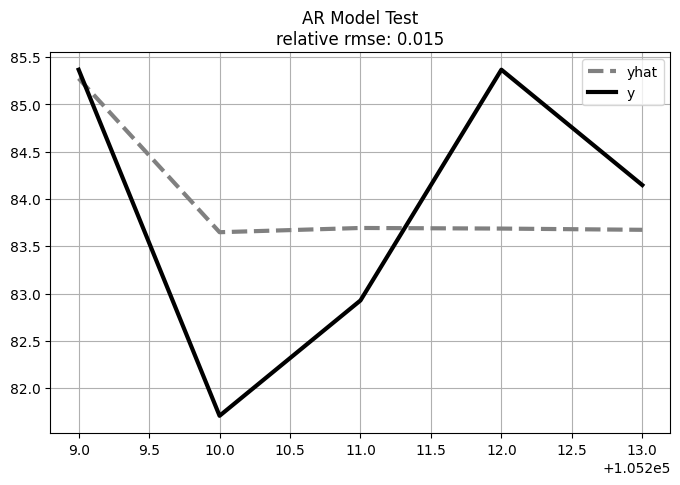

In [6]:
from zero_ts_demo import models as mod
df = MODEL_DATA.copy()
col = 'mt_005'

# prepare a training and test dataset for one of the time series in MODEL_DATA
slr, sle = mod.train_test(MODEL_DATA.copy(), col, rolling=3, tail=0)

# fit model, make a prediction and then plot 
armodel = mod.StatsmodelsARModel(slr, sle, title='AR Model Test')
armodel.fit_predict(dynamic=True)
armodel.plot_preds(plotwidth=8)

...in the above graph, the predicted value, `yhat`, is the dotted line and the actual value is the solid black line. The metric "Relative RMSE" is included (below the title of the graph), which can be conceptually thought of as "the average percent error of the prediction". In this case, we already have a plausible prediction! 

Let's inspect the model a bit more:

In [7]:
armodel.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:               105209
Model:                     AutoReg(5)   Log Likelihood             -274135.876
Method:               Conditional MLE   S.D. of innovations              3.277
Date:                Sun, 25 Aug 2024   AIC                         548285.752
Time:                        13:44:55   BIC                         548352.697
Sample:                             5   HQIC                        548306.022
                               105209                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.010      0.013      0.990      -0.020       0.020
y.L1           0.3711      0.003    120.391      0.000       0.365       0.377
y.L2          -0.2389      0.003    -72.727      0.000      -0.245      -0.232
y.L3           0.1006      0.003     30.020      0.000       0.094       0.107
y.L4          -0.0453      0.003    -13.779      0.000      -0.052      -0.039
y.L5           0.0254      0.003      8.241      0.000       0.019       0.031
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0531           -1.7911j            2.0777           -0.3346
AR.2           -1.0531           +1.7911j            2.0777            0.3346
AR.3            2.2107           -0.0000j            2.2107           -0.0000
AR.4            0.8387           -1.8499j            2.0312           -0.1823
AR.5            0.8387           +1.8499j            2.0312            0.1823
-----------------------------------------------------------------------------
"""

...in the above tables, we can see some basic stats about the regression and the values of the coefficients. Note that this is an `AutoReg(5)` model, which means that the `statsmodels` code determined that a model order (i.e. $p$ value) of the model is 5. 

`statsmodels` also offers automatic regression diagnostic plots:

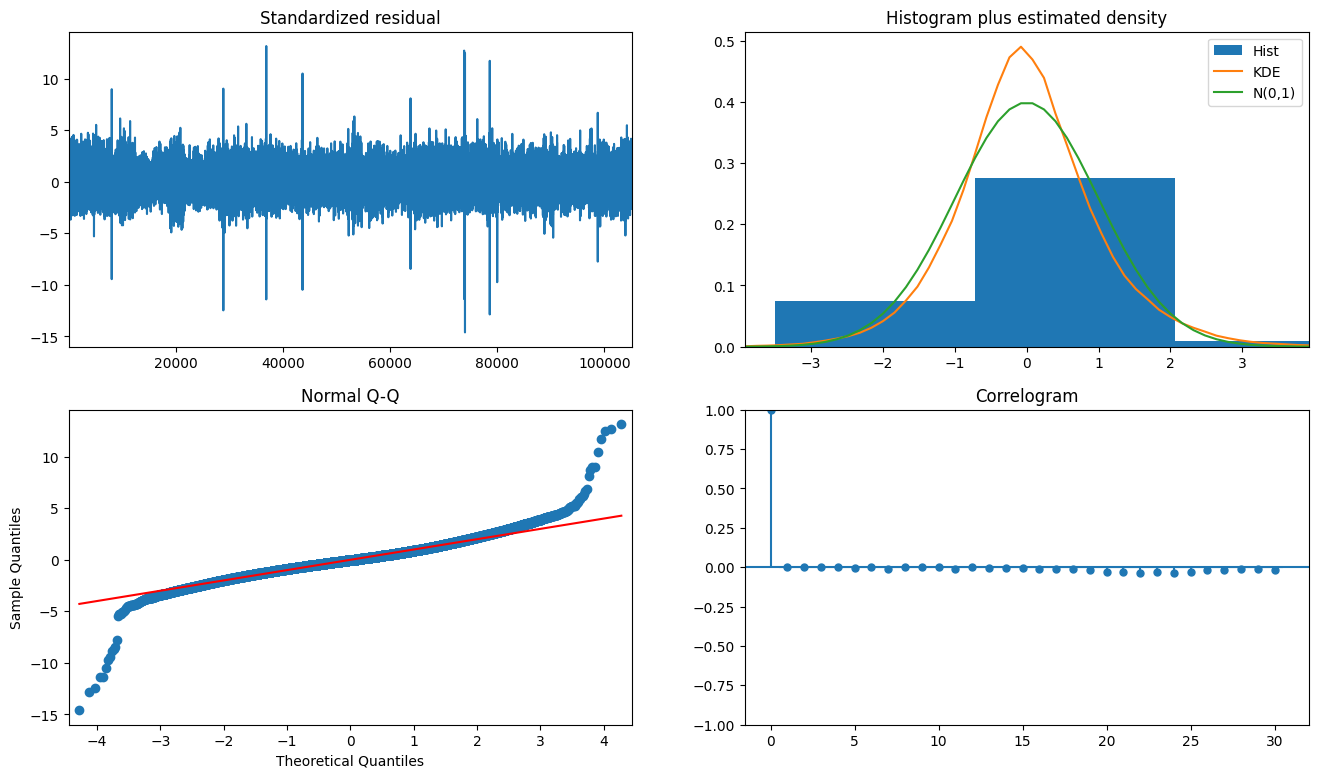

In [8]:
fig = plt.figure(figsize=(16, 9))
fig = armodel.model.plot_diagnostics(fig=fig, lags=30)

... not too bad! On the top left graph, we can see that the in-sample model errors are centered approximately around zero, and in the bottom right graph we can see that there is virtually no correlation between in-sample errors and past values of the data. 

Ideally, the Normal Q-Q plot (bottom left) would have all of the dots lined up on the red line, however at the two extremes the data are skewed. This means that the model makes larger forecasting errors when the values of kW are very high or very low. 

These energy consumption time series are prone to infrequent, rapid and large changes in value. This is a substantial challenge to accurate prediction of these time series and further optimization to that end is beyond the scope of this notebook.

Given that the predictions for this single time series are centered around zero and, on average, fairly accurate, let's extend the same code to the other 300+ time series in `MODEL_DATA`

# Evaluate Across All Series

For every time series in `MODEL_DATA` (correponding to the columns), we will A) create a train/test split, B) fit the model using our `StatsmodelsARModel` class, and retain the relative RMSE metric. Then we can analyze these out-of-sample predictions, comparing predictions across different time series.

In [9]:
model_rmse = dict()

for col in [col for col in MODEL_DATA.columns if not MODEL_DATA[col].iloc[-1] == 0]:
    slr, sle = mod.train_test(MODEL_DATA.copy(), col, rolling=3, tail=0)
    armodel = mod.StatsmodelsARModel(slr, sle, title=col)
    armodel.fit_predict(dynamic=True)
    model_rmse[col] = armodel.rmse_relative

In [10]:
d = pd.DataFrame.from_dict(model_rmse, orient='index')
d.columns = ['rmse_relative']
d.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,rmse_relative
count,307.000000
mean,0.114212
std,0.202292
min,0.009119
10%,0.024999
25%,0.043042
50%,0.071912
75%,0.114611
90%,0.216729
max,2.490254


...let's take a moment to recap, for each of the 308 time series, we have completed the following steps:

* Create a train/test split, where we retain the last 5 values of the series for model evaluation (`train_test` method).
* Fit the autoregressive model, automatically finding the best order using `statsmodels` (`fit_predict` method).
* Made a prediction and calculated the relative RMSE (also `fit_predict` method).

...and in the above table, we're summarizing the relative RMSE across all 308 time series. 

We might be inclined to think that we have a useful model here, however there is a lot more work that needs to be done. Even though the median prediction is fairly accurate (the average error was about 7%), there are many predictions which are extremely inaccurate:

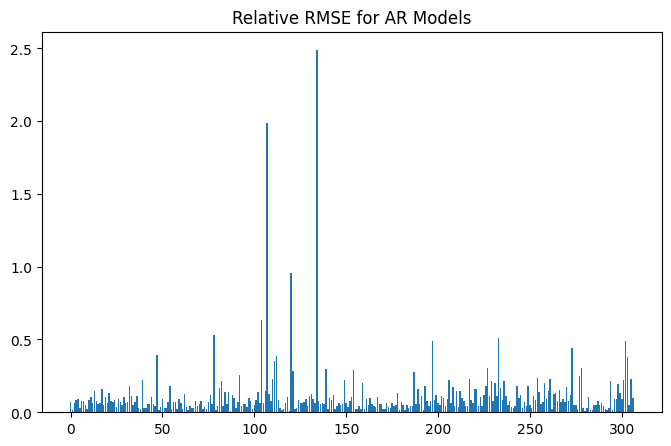

In [18]:
w = 8
fig, ax = plt.subplots(figsize=(w, w/1.618))

x = range(len(d))
y = d['rmse_relative']
ax.bar(x, y)
ax.set_title('Relative RMSE for AR Models')
plt.show()

...it isn't likely that this model would be very useful. The median prediction is inaccurate by about 7%, which might be feasible, however there are many predictions which are upwards of 20% inaccurate. Imagine telling an energy producer that electricity demand is predicted to increase by 250% and then being wrong! 

Further work might include implementing more sophisticated models and bringing in external data (e.g. in this case of electricity demand, we might want to utilize a weather forecast to use as part of the prediction). 

# Scratchpad